### Note
This file is an adaptation of the retraining example by tensorflow.
The only adaptations are made to load my own training data and files.
It stores an normal .pb model and an compressed .tflight model (that will be useed in the extension down the road)

##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Retraining an Image Classifier


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf2_image_retraining"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Introduction

Image classification models have millions of parameters. Training them from
scratch requires a lot of labeled training data and a lot of computing power. Transfer learning is a technique that shortcuts much of this by taking a piece of a model that has already been trained on a related task and reusing it in a new model.

This Colab demonstrates how to build a Keras model for classifying five species of flowers by using a pre-trained TF2 SavedModel from TensorFlow Hub for image feature extraction, trained on the much larger and more general ImageNet dataset. Optionally, the feature extractor can be trained ("fine-tuned") alongside the newly added classifier.

### Looking for a tool instead?

This is a TensorFlow coding tutorial. If you want a tool that just builds the TensorFlow or TF Lite model for, take a look at the [make_image_classifier](https://github.com/tensorflow/hub/tree/master/tensorflow_hub/tools/make_image_classifier) command-line tool that gets [installed](https://www.tensorflow.org/hub/installation) by the PIP package `tensorflow-hub[make_image_classifier]`, or at [this](https://colab.sandbox.google.com/github/tensorflow/examples/blob/master/tensorflow_examples/lite/model_maker/demo/image_classification.ipynb) TF Lite colab.


## Setup

In [2]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.2.0
Hub version: 0.7.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is NOT AVAILABLE


## Select the TF2 SavedModel module to use

For starters, use https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4. The same URL can be used in code to identify the SavedModel and in your browser to show its documentation. (Note that `hub.Modules` for TF 1.x won't work here.)

In [3]:
module_selection = ("mobilenet_v2_100_224", 224) #@param ["(\"mobilenet_v2_100_224\", 224)", "(\"inception_v3\", 299)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32 #@param {type:"integer"}

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


## Set up the Flowers dataset

Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

In [4]:
root_data_path = 'data/train/thumbnails/'

data_dir = os.path.join(root_data_path, 'data/')
model_dir = os.path.join(root_data_path, 'model/')

In [7]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 3281 images belonging to 2 classes.
Found 13129 images belonging to 2 classes.


## Defining the model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [9]:
do_fine_tuning = False #@param {type:"boolean"}

In [14]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


## Training the model

In [15]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [12]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/5
410/410 [==============================] - 280s 683ms/step - loss: 0.6329 - accuracy: 0.7351 - val_loss: 0.8478 - val_accuracy: 0.7154
Epoch 2/5
410/410 [==============================] - 282s 689ms/step - loss: 0.6291 - accuracy: 0.7449 - val_loss: 0.9257 - val_accuracy: 0.5794
Epoch 3/5
410/410 [==============================] - 279s 681ms/step - loss: 0.6133 - accuracy: 0.7502 - val_loss: 0.6554 - val_accuracy: 0.7123
Epoch 4/5
410/410 [==============================] - 268s 653ms/step - loss: 0.6093 - accuracy: 0.7505 - val_loss: 0.6282 - val_accuracy: 0.7592
Epoch 5/5
410/410 [==============================] - 274s 670ms/step - loss: 0.6053 - accuracy: 0.7553 - val_loss: 0.5883 - val_accuracy: 0.7819


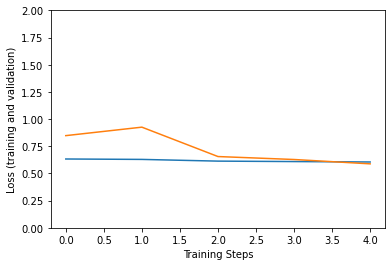

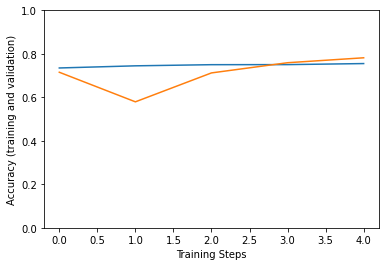

In [13]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

Finally, the trained model can be saved for deployment to TF Serving or TF Lite (on mobile) as follows.

In [19]:
saved_model_path = os.path.join(model_dir, 'tf_model')
tf.saved_model.save(model, saved_model_path)

## Optional: Deployment to TensorFlow Lite

[TensorFlow Lite](https://www.tensorflow.org/lite) lets you deploy TensorFlow models to mobile and IoT devices. The code below shows how to convert the trained model to TF Lite and apply post-training tools from the [TensorFlow Model Optimization Toolkit](https://www.tensorflow.org/model_optimization). Finally, it runs it in the TF Lite Interpreter to examine the resulting quality

  * Converting without optimization provides the same results as before (up to roundoff error).
  * Converting with optimization without any data quantizes the model weights to 8 bits, but inference still uses floating-point computation for the neural network activations. This reduces model size almost by a factor of 4 and improves CPU latency on mobile devices.
  * On top, computation of the neural network activations can be quantized to 8-bit integers as well if a small reference dataset is provided to calibrate the quantization range. On a mobile device, this accelerates inference further and makes it possible to run on accelerators like EdgeTPU.

In [27]:
#@title Optimization settings
# docs_infra: no_execute
# TODO(b/156102192)
optimize_lite_model = True  #@param {type:"boolean"}
#@markdown Setting a value greater than zero enables quantization of neural network activations. A few dozen is already a useful amount.
num_calibration_examples = 100  #@param {type:"slider", min:0, max:1000, step:1}
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_generator for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open(os.path.join(model_dir, 'saved_model.tflite'), "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

Wrote optimized TFLite model of 2970000 bytes.


In [28]:
# docs_infra: no_execute
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TF Lite interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [29]:
#@markdown For rapid experimentation, start with a moderate number of examples.
# docs_infra: no_execute
num_eval_examples = 100  #@param {type:"slider", min:0, max:700}
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_generator
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TF Lite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TF Lite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))

TF Lite model agrees with original model on 98 of 100 examples (98%).
TF Lite model is accurate on 80 of 100 examples (80%).
